<a href="https://www.kaggle.com/code/nikhilkhetan/setting-up-evaluation-metrics?scriptVersionId=99852231" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Index

1. Introduction
2. Supervised vs Unsupervised Learning (with and without ground truth labels)
3. Clustering algorithms
4. Evaluation metrics for clustering (with ground truth labels)
5. Evaluation metrics for clustering (without ground truth labels)
6. Comparision of clustering models
7. Conclusion
8. References

# 1. Introduction

#### Kaggle never stops to amaze us with the monthly TPS competitions. This month's TPS is a fully unsupervised clustering challenge. We do not have any training data and we do not even know the number of clusters. As stated in the description of the competition, this makes the challenge similar to a real world setting.

#### For any Machine learning challenge, it helps to have a Single number evaluation metric to compare various models against one another and it also helps in deciding what to do next.

#### In this notebook, we will go through some of these metrics that can be used in a fully unsupervised setting and we will also compare a few models against one another.

#### Before we get started, a couple of disclaimers:

##### 1. The main idea of this notebook is to show how to set up an evaluation metric. As such, focus has not been put on the output of the clustering algorithms and some of the visualizations obtained are highly overlapping.

##### 2. PCA (with 2 components) has been used to simplify the visualization process.

# 2. Supervised vs Unsupervised Learning

#### A Supervised learning problem is when we provide our model with the output labels for training i.e. we have both the X and y for the entire training set and the model gets to see these while training.

#### Unsupervised learning is when our model gets to see only the X and not the y while training. The model does not know what the actual ground truth labels are for the training set and has to draw inferences based only on the X.

#### Unsupervised learning does not necessarily mean that "y" does not exist rather just that the model does not get to see it. So, we can broadly classify Unsupervised learning into two categories:

##### 1. Where we have the ground truth labels for the training set
##### 2. Where the ground truth labels does not exist

#### This competition falls in the 2nd category since we are not provided with any training set or ground truth labels.

#### Below is a snippet from sklearn

> Evaluating the performance of a clustering algorithm is not as trivial as counting the number of errors or the precision and recall of a supervised classification algorithm. In particular any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar than members of different classes according to some similarity metric.

# 3. Clustering Algorithms

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2022/data.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from numpy import unique
from numpy import where

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics.cluster import pair_confusion_matrix

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

In [3]:
df = pd.read_csv('../input/tabular-playground-series-jul-2022/data.csv', index_col='id')

In [4]:
df.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
id,,,,,,,,,,,,,,,,,,,,,
0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,5,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,13,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,5,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98000 entries, 0 to 97999
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_00    98000 non-null  float64
 1   f_01    98000 non-null  float64
 2   f_02    98000 non-null  float64
 3   f_03    98000 non-null  float64
 4   f_04    98000 non-null  float64
 5   f_05    98000 non-null  float64
 6   f_06    98000 non-null  float64
 7   f_07    98000 non-null  int64  
 8   f_08    98000 non-null  int64  
 9   f_09    98000 non-null  int64  
 10  f_10    98000 non-null  int64  
 11  f_11    98000 non-null  int64  
 12  f_12    98000 non-null  int64  
 13  f_13    98000 non-null  int64  
 14  f_14    98000 non-null  float64
 15  f_15    98000 non-null  float64
 16  f_16    98000 non-null  float64
 17  f_17    98000 non-null  float64
 18  f_18    98000 non-null  float64
 19  f_19    98000 non-null  float64
 20  f_20    98000 non-null  float64
 21  f_21    98000 non-null  float64
 22

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
f_00,98000.0,0.001220,1.002801,-4.732235,-0.675226,0.002022,0.677271,4.490521
f_01,98000.0,0.005580,1.000742,-4.202795,-0.670985,0.006650,0.677746,4.324974
f_02,98000.0,-0.001042,1.001373,-4.377021,-0.672779,-0.000324,0.677086,4.560247
f_03,98000.0,-0.000700,1.000422,-4.010826,-0.672540,-0.003185,0.672097,4.399373
f_04,98000.0,-0.003522,1.003061,-4.535903,-0.682510,-0.003307,0.677589,4.050549
f_05,98000.0,-0.001612,1.000532,-4.300767,-0.675066,0.001024,0.673344,4.710316
f_06,98000.0,-0.003042,0.997434,-4.894525,-0.680421,-0.002053,0.668112,3.998595
f_07,98000.0,5.545918,3.691840,0.000000,3.000000,5.000000,8.000000,32.000000
f_08,98000.0,6.763061,4.152348,0.000000,4.000000,6.000000,9.000000,30.000000
f_09,98000.0,8.193163,5.904919,0.000000,4.000000,7.000000,11.000000,44.000000


In [7]:
#Perform PCA to obtain first 2 components for easy visualization
pca = PCA(2)
pca_data=pca.fit_transform(df)

#Perform Scaling
scaler = StandardScaler()
norm_data = scaler.fit_transform(pca_data)

norm_data = pd.DataFrame(data=norm_data, columns = ['col1', 'col2'])
norm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,98000.0,5.945358e-18,1.000005,-2.521968,-0.699413,-0.215718,0.523145,5.467491
col2,98000.0,-5.437827e-18,1.000005,-3.497592,-0.697996,-0.128046,0.612172,4.637116


## 3.1 K-Means

In [8]:
kmeans = KMeans(n_clusters=2, max_iter=500)
kmeans_labels = kmeans.fit_predict(norm_data)

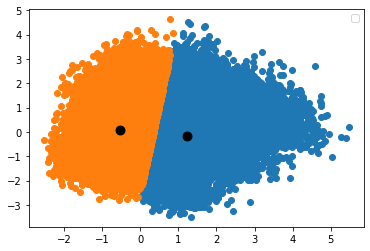

In [9]:
#Getting unique labels
centroids = kmeans.cluster_centers_
u_labels = np.unique(kmeans_labels)
 
#plotting the results:
 
for i in u_labels:
    filtered_data = norm_data[kmeans_labels==i]
    plt.scatter(filtered_data.iloc[:, 0] , filtered_data.iloc[:,1])
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

## 3.2 DBSCAN

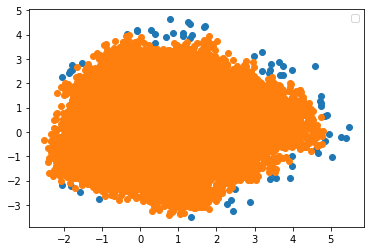

In [10]:
# define the model
dbscan_model = DBSCAN(eps=0.25, min_samples=9)

# train the model
dbscan_model.fit(norm_data)

# assign each data point to a cluster
dbscan_labels = dbscan_model.labels_

# get all of the unique clusters
dbscan_clusters = unique(dbscan_labels)

for i in dbscan_clusters:
    # get data points that fall in this cluster
    filtered_data = norm_data[dbscan_labels==i]
    plt.scatter(filtered_data.iloc[:, 0] , filtered_data.iloc[:,1])
# show the DBSCAN plot
plt.legend()
plt.show()

## 3.3 Gaussian Mixture Model

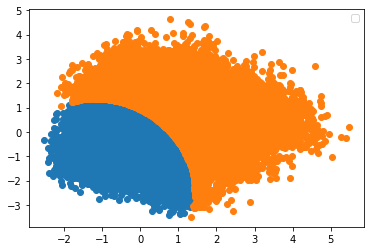

In [11]:
# define the model
gaussian_model = GaussianMixture(n_components=2)

# train the model
gaussian_model.fit(norm_data)

# assign each data point to a cluster
gaussian_labels = gaussian_model.predict(norm_data)

# get all of the unique clusters
gaussian_clusters = unique(gaussian_labels)

for i in gaussian_clusters:
    # get data points that fall in this cluster
    filtered_data = norm_data[gaussian_labels==i]
    plt.scatter(filtered_data.iloc[:, 0] , filtered_data.iloc[:,1])
# show the plot
plt.legend()
plt.show()

# 4. Evaluation metrics for clustering (with ground truth labels)

#### In settings where we have the actual ground truth labels, evaluation is intuitive and there are various methods to compare the actual labels with the predicted labels. Let's go through some of them.

## 4.1 Rand Index and Adjusted Rand Index

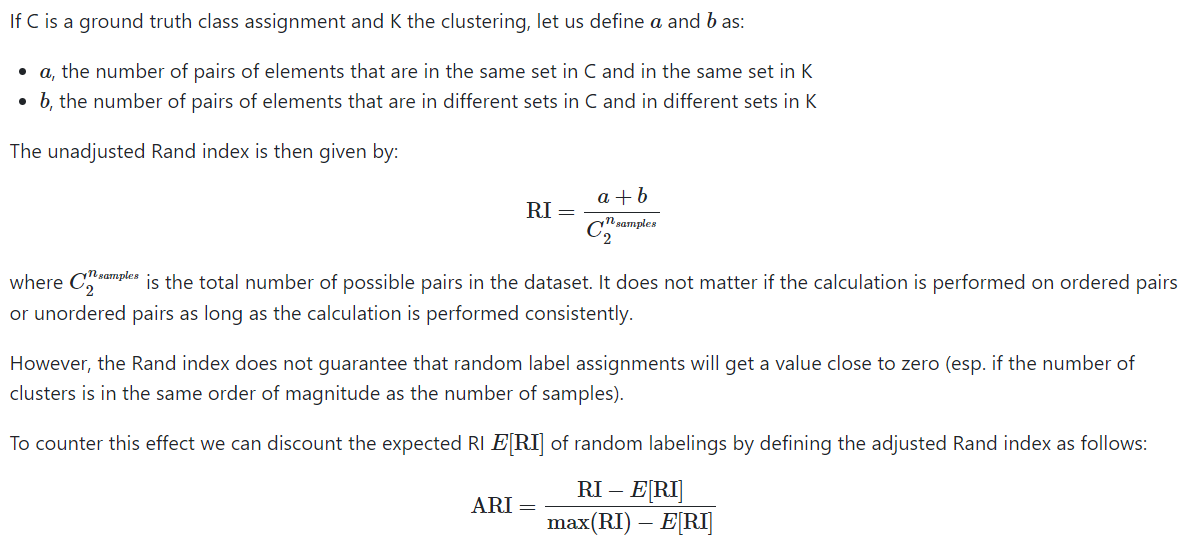

> Given the knowledge of the ground truth class assignments **labels_true** and our clustering algorithm assignments of the same samples **labels_pred**, the (adjusted or unadjusted) Rand index is a function that measures the similarity of the two assignments, ignoring permutations

In [12]:
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
metrics.rand_score(labels_true, labels_pred)

0.6666666666666666

> The Rand index does not ensure to obtain a value close to 0.0 for a random labelling. The adjusted Rand index corrects for chance and will give such a baseline.

In [13]:
metrics.adjusted_rand_score(labels_true, labels_pred)

0.24242424242424243

### **The adjusted Rand Index is the evaluation metric for this competition but we cannot use it to compare our models as we do not have the ground truth labels.**

## 4.2 Homogeneity, completeness and V score

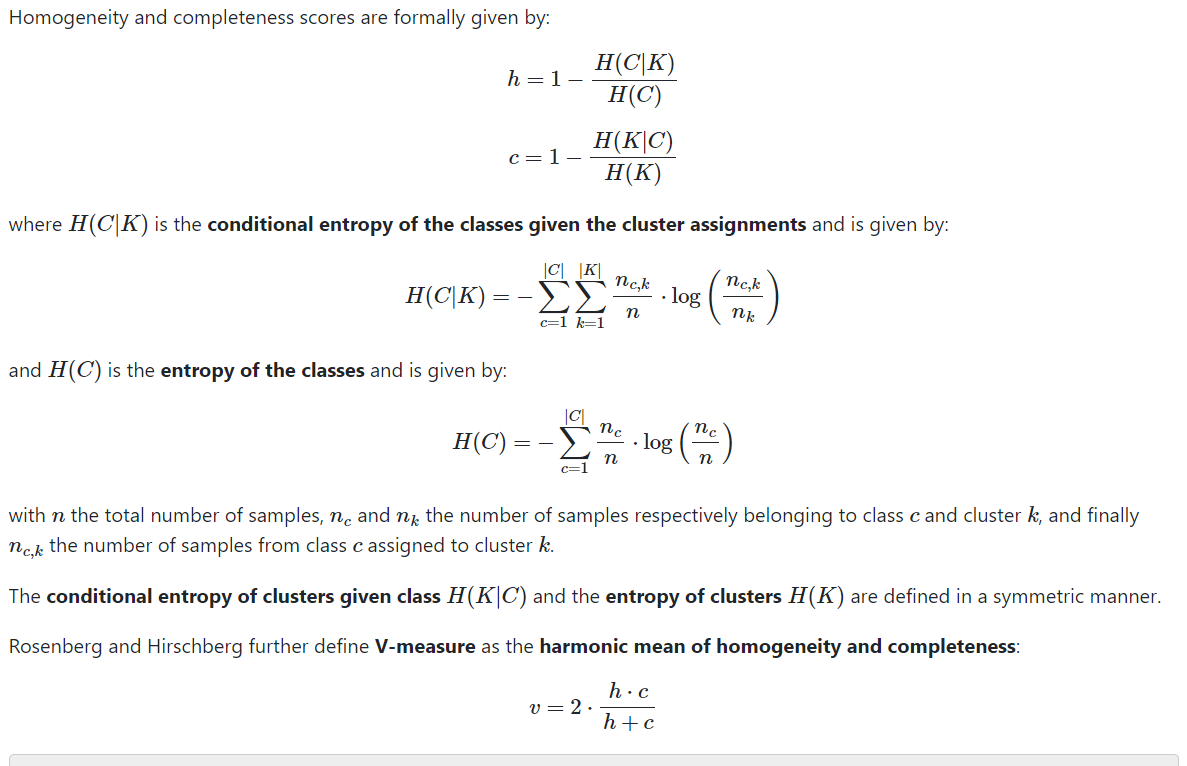

#### **Homogeneity:** Each cluster contains only members from a single class
#### **Completeness:** All members of a given class are assigned to the same cluster

In [14]:
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

metrics.homogeneity_score(labels_true, labels_pred)

0.6666666666666669

In [15]:
metrics.completeness_score(labels_true, labels_pred)

0.420619835714305

In [16]:
metrics.v_measure_score(labels_true, labels_pred)

0.5158037429793889

#### Homogeneity, completeness and V-measure can be computed at once

In [17]:
metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)

(0.6666666666666669, 0.420619835714305, 0.5158037429793889)

## 4.3 Fowlkes-Mallows scores

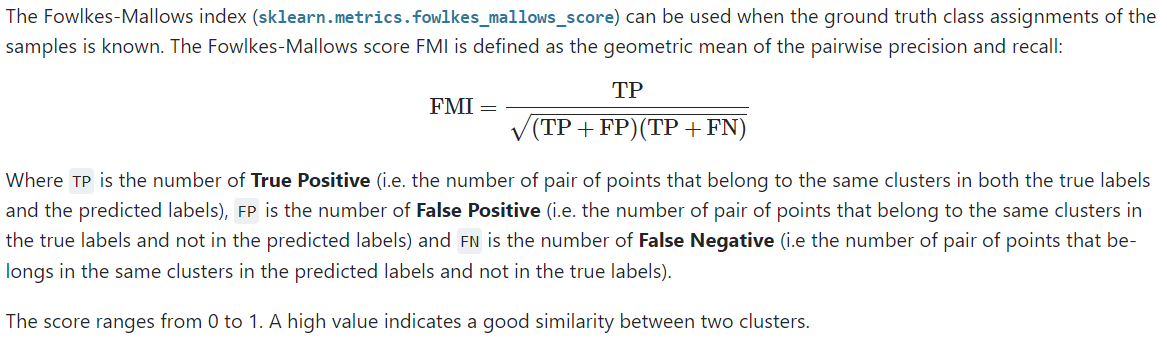

In [18]:
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

metrics.fowlkes_mallows_score(labels_true, labels_pred)

0.4714045207910317

## 4.4 Pair Confusion Matrix

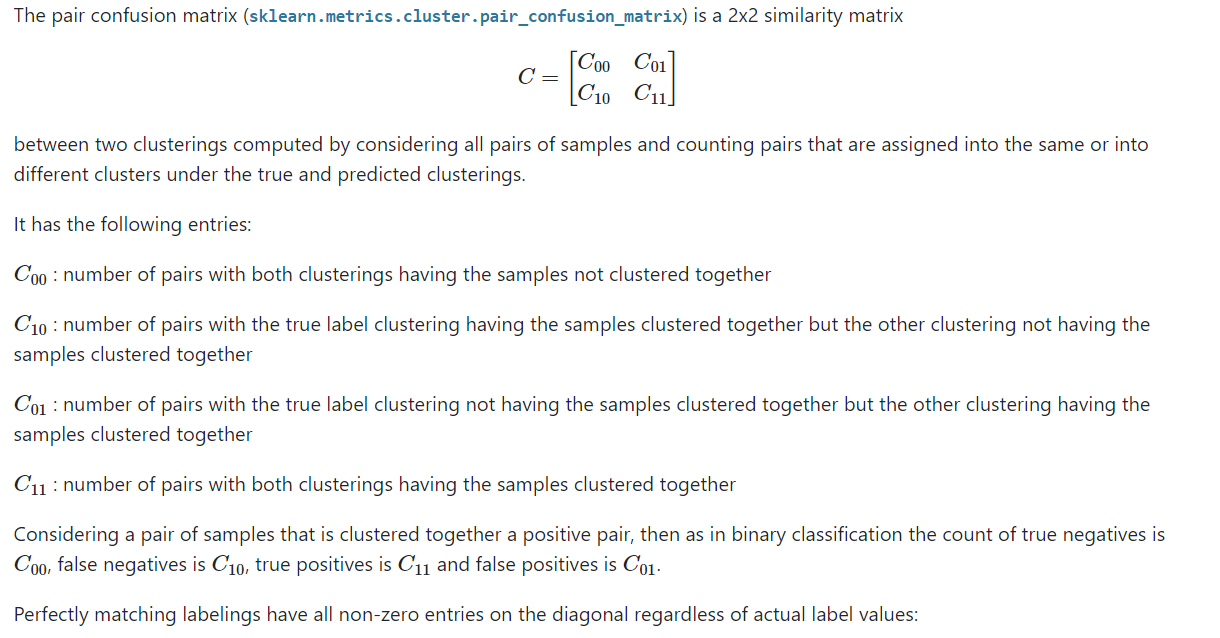

In [19]:
pair_confusion_matrix([0, 0, 1, 1], [0, 0, 1, 1])

array([[8, 0],
       [0, 4]])

In [20]:
pair_confusion_matrix([0, 0, 0, 0], [0, 1, 2, 3])

array([[ 0,  0],
       [12,  0]])

# 5. Evaluation metrics for clustering (without ground truth labels)

## 5.1 Silhouette Coefficient

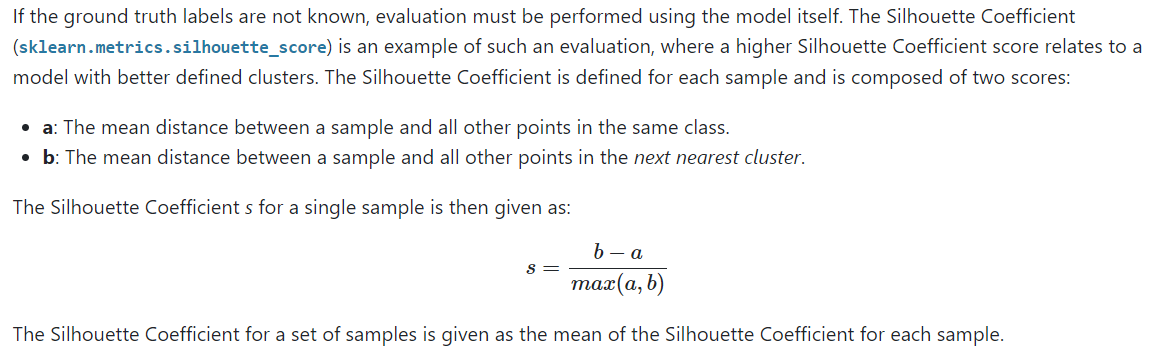

In [21]:
kmeans_silhouette = metrics.silhouette_score(norm_data, kmeans_labels, metric='euclidean')
dbscan_silhouette = metrics.silhouette_score(norm_data, dbscan_labels, metric='euclidean')
gaussian_silhouette = metrics.silhouette_score(norm_data, gaussian_labels, metric='euclidean')

## 5.2 Calinski Harabasz Score

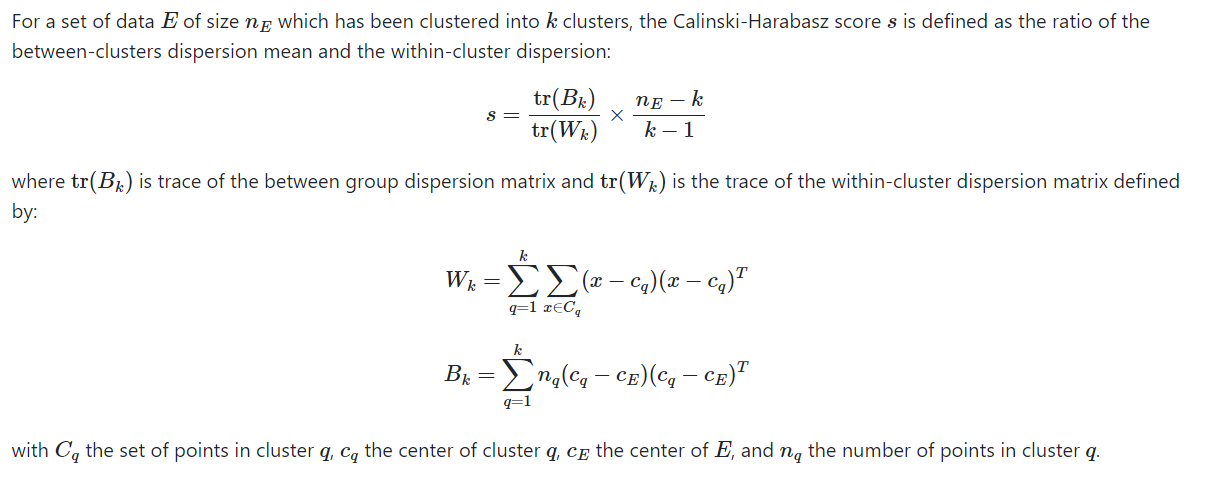

In [22]:
kmeans_ch = metrics.calinski_harabasz_score(norm_data, kmeans_labels)
dbscan_ch = metrics.calinski_harabasz_score(norm_data, dbscan_labels)
gaussian_ch = metrics.calinski_harabasz_score(norm_data, gaussian_labels)

### 5.3 Davies Bouldin Index

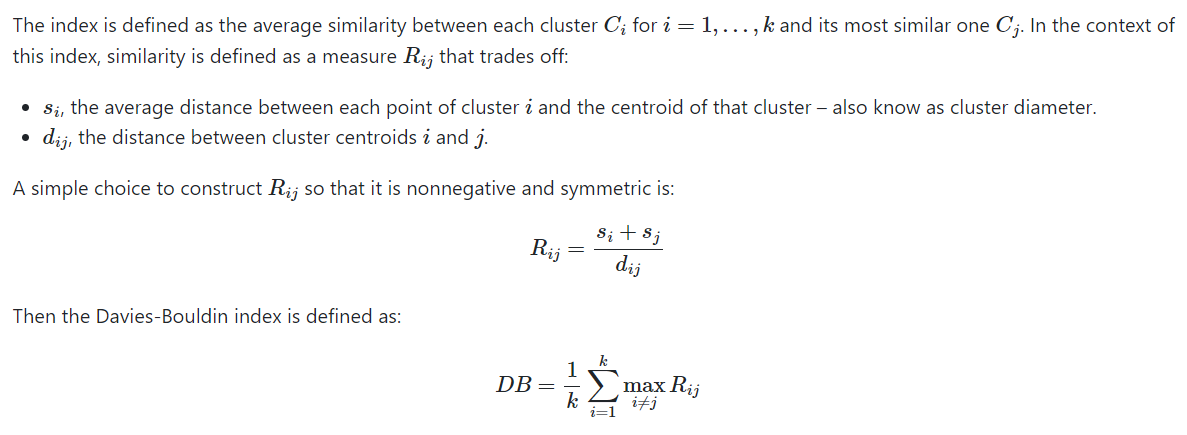

In [23]:
kmeans_db = metrics.davies_bouldin_score(norm_data, kmeans_labels )
dbscan_db = metrics.davies_bouldin_score(norm_data, dbscan_labels)
gaussian_db = metrics.davies_bouldin_score(norm_data, gaussian_labels)

# 6. Comparision of clustering models

In [24]:
data = [
    ['KMeans',kmeans_silhouette, kmeans_ch, kmeans_db], 
    ['DBSCAN', dbscan_silhouette, dbscan_ch, dbscan_db],
    ['Gaussian Mixture Model', gaussian_silhouette, gaussian_ch, gaussian_db]
       ]

result = pd.DataFrame(data, columns=['Model', 'Silhouette_Score', 'Calinski_Harabasz_Score', 'Davies_Bouldin_Index'])

result

,Model,Silhouette_Score,Calinski_Harabasz_Score,Davies_Bouldin_Index
0,KMeans,0.361810,48591.066180,1.161319
1,DBSCAN,0.589983,214.995614,1.756211
2,Gaussian Mixture Model,0.380498,41677.241396,1.343699


### For the Silhouette score and CH score, a higher number is better while for DB score, lower is better.

# 7. Future Work

1. To include a few more models (BIRCH, OPTICS), etc.
2. To include variations of models with more #clusters
3. To include a time comparision of the metrics

# 8. References

1. [sklearn Clustering Performance Evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)
2. [Intro to Clustering](https://www.kaggle.com/code/azminetoushikwasi/intro-to-clustering-techniques-algorithms) by @azminetoushikwasi
3. [Plotting Clusters](https://www.askpython.com/python/examples/plot-k-means-clusters-python)